# ViT License Plate Detection

This notebook trains ViT on images of license plate.

Ref https://keras.io/examples/vision/object_detection_using_vision_transformer/

## Import Packages

In [1]:
import os

os.environ["KERAS_BACKEND"] = "torch" 

import numpy as np
import keras
from keras import layers
from keras import ops
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import scipy.io
import shutil

from datasets import load_dataset, Dataset

/home/cameron/Documents/UBC Course Materials/2023W2/CPSC 440/license-plate-recognition/vit/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Path to Images and Annotations

### Vehicle Dataset

In [2]:
ds = load_dataset("keremberke/license-plate-object-detection", name="full")

In [3]:
def get_data(data):
    images = []
    targets = []
    for i in range(0, len(data)):
        img = data[i]
        for j in range(len(img['objects']['bbox'])):
            box = img['objects']['bbox'][j]
            top_left_x = box[0]
            top_left_y = box[1]
            bottom_right_x = box[0] + box[2]
            bottom_right_y = box[1] + box[3]
        
            image = img['image']
            (w, h) = image.size[:2]
        
            # resize images
            image = image.resize((image_size, image_size))
        
            # convert image to array and append to list
            images.append(keras.utils.img_to_array(image))
        
            # apply relative scaling to bounding boxes as per given image and append to list
            targets.append(
                (
                    float(top_left_x) / w,
                    float(top_left_y) / h,
                    float(bottom_right_x) / w,
                    float(bottom_right_y) / h,
                )
            )
    return images, targets

In [4]:
image_size = 224  # resize input images to this size

images_train, targets_train = get_data(ds["train"])
(x_train), (y_train) = np.asarray(images_train), np.asarray(targets_train)
images_val, targets_val = get_data(ds["validation"])
(x_val), (y_val) = np.asarray(images_val), np.asarray(targets_val)
images_test, targets_test = get_data(ds["test"])
(x_test), (y_test) = np.asarray(images_test), np.asarray(targets_test)

## MultiLayer Perceptron

In [5]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Image Patches

In [6]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config


## Display Patches

Image size: 224 X 224
Patch size: 32 X 32
49 patches per image 
3072 elements per patch


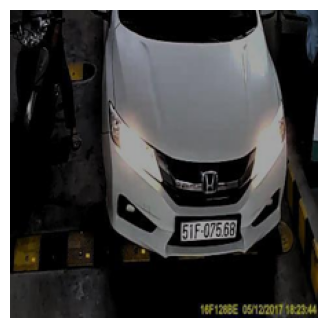

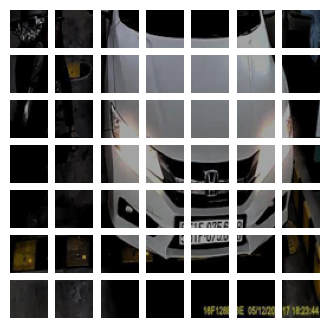

In [7]:
patch_size = 32  # Size of the patches to be extracted from the input images

plt.figure(figsize=(4, 4))
plt.imshow(x_train[0].astype("uint8"))
plt.axis("off")

patches = Patches(patch_size)(np.expand_dims(x_train[0], axis=0))
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"{patches.shape[1]} patches per image \n{patches.shape[-1]} elements per patch")


n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")


## Patch Encoding

In [8]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    # Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded


## Build VIT Model

In [9]:
def create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
):
    inputs = keras.Input(shape=input_shape)
    # Create patches
    patches = Patches(patch_size)(inputs)
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.3)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.3)

    bounding_box = layers.Dense(4)(
        features
    )  # Final four neurons that output bounding box

    # return Keras model.
    return keras.Model(inputs=inputs, outputs=bounding_box)


## Train Model

Training using an RTX 3080 takes ~40ms/step. Takes about 40 minutes to train at 300 epochs where 8s/epoch

In [11]:
def run_experiment(model, learning_rate, weight_decay, batch_size, num_epochs):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    # Compile model.
    model.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError())

    checkpoint_filepath = "vit_license_plate_detector.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_val,y_val),
        callbacks=[
            checkpoint_callback,
        ],
    )

    return history


input_shape = (image_size, image_size, 3)  # input image shape
learning_rate = 0.00001
weight_decay = 0.0001
batch_size = 32
num_epochs = 300
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
# Size of the transformer layers
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 4
mlp_head_units = [2048, 1024, 512, 64, 32]  # Size of the dense layers


history = []
num_patches = (image_size // patch_size) ** 2

In [ ]:
vit_object_detector = create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
)

# Train model
history = run_experiment(
    vit_object_detector, learning_rate, weight_decay, batch_size, num_epochs
)


def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")

## Save Model

In [ ]:
# Saves the model in current path
vit_object_detector.save("vit_license_plate_detector.keras")

## Load Model

In [12]:
vit_object_detector = create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
)
vit_object_detector.load_weights("vit_license_plate_detector.weights.h5")

## Evaluate

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
[0.55129623 0.6706892  0.7245028  0.7842433 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[0.5114874  0.71000516 0.69163024 0.8227128 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[0.51177305 0.53483635 0.6571728  0.63393116]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[0.3859825 0.6017579 0.5618768 0.7420539]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[0.40812212 0.40193582 0.586322   0.53616536]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[0.5745474  0.711391   0.74976337 0.82278097]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[0.46661928 0.48859268 0.5466931  0.53207034]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[0.30938786 0.27652952 0.47733068 0.37033087]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[0.40496242 0.306735   0.5724822  0.5039189 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[0.4340348  0.48008442 0.5683028  0.575714  ]
mean_iou: 0.2786905167865047


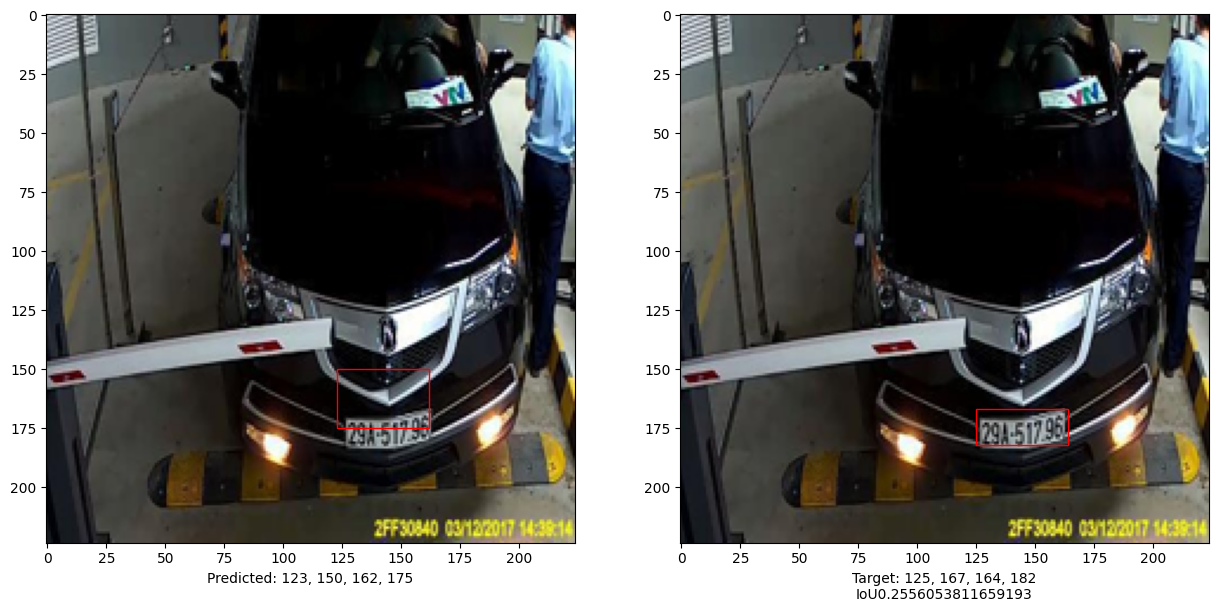

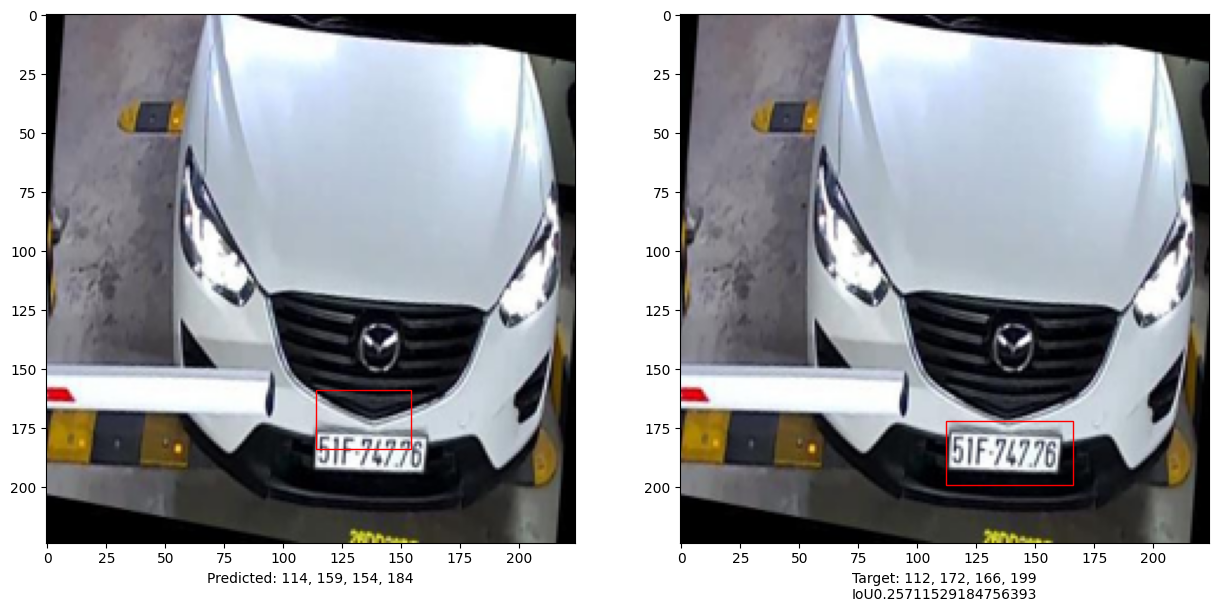

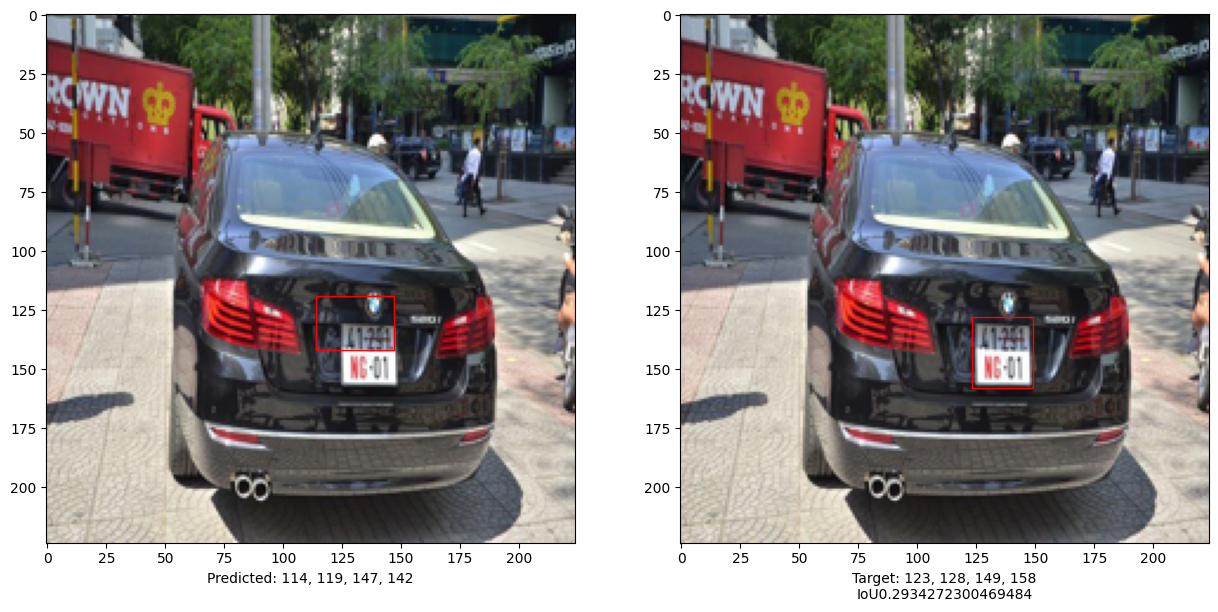

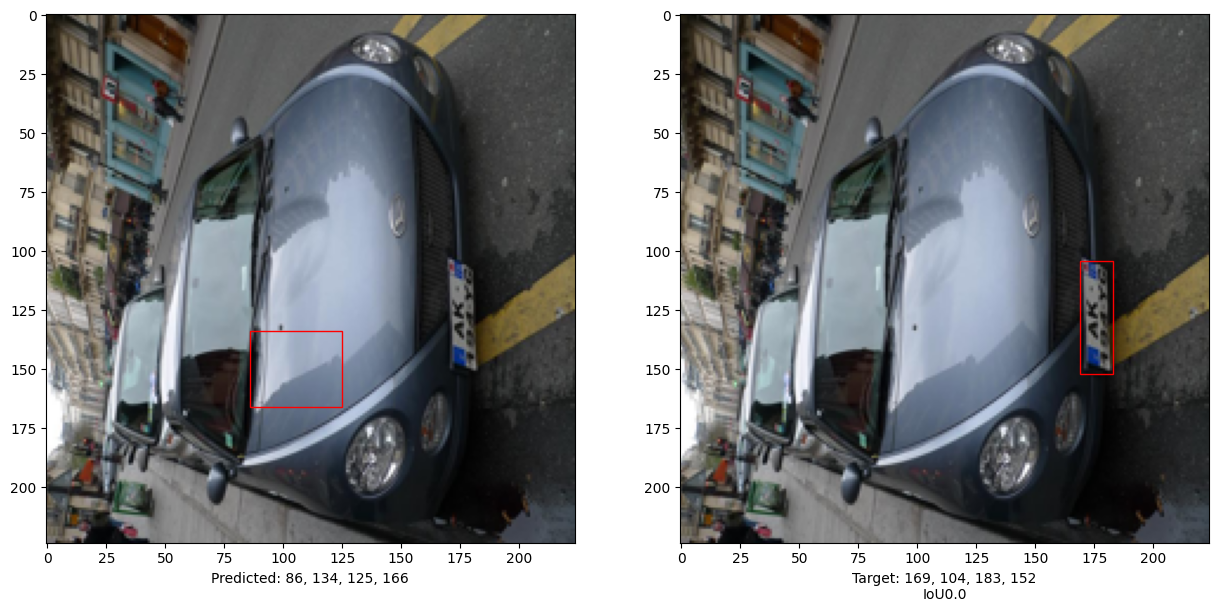

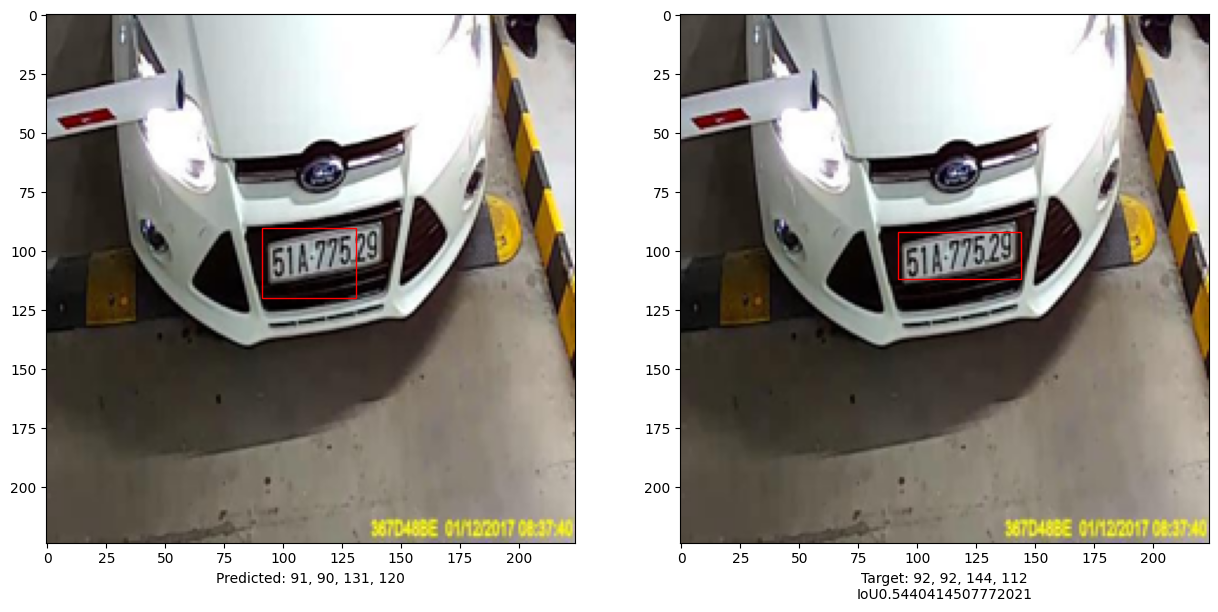

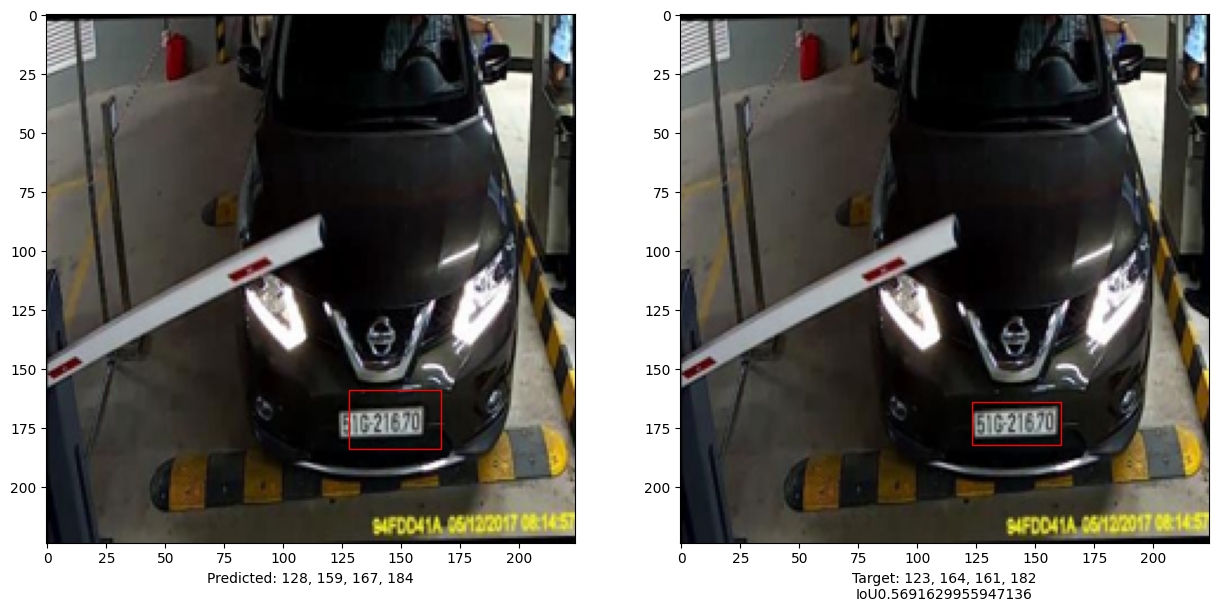

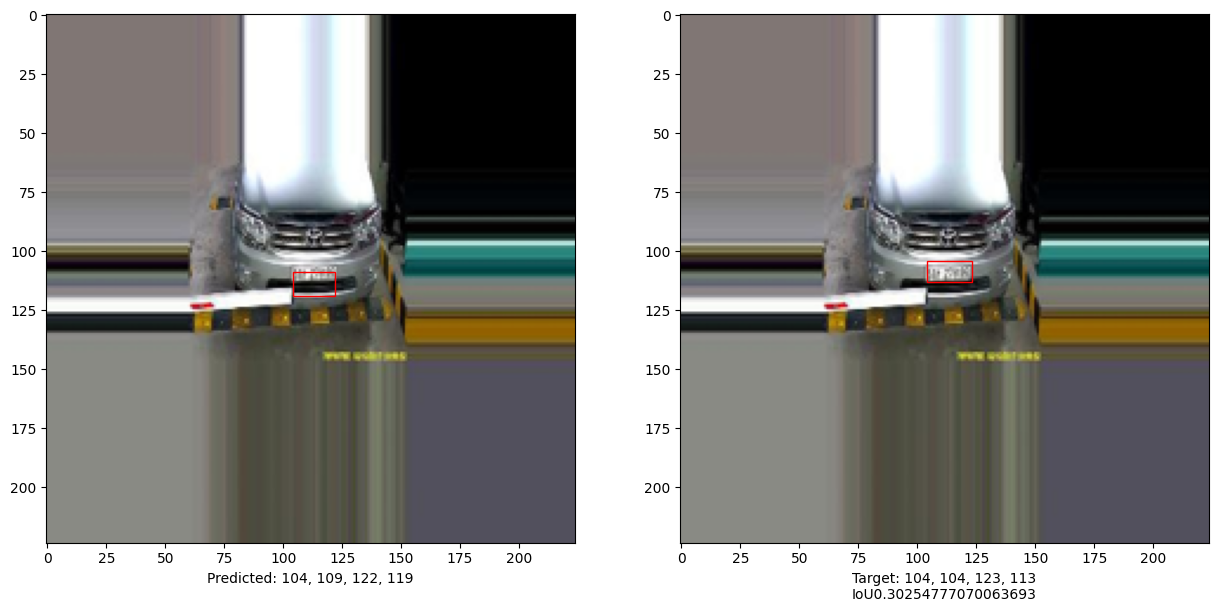

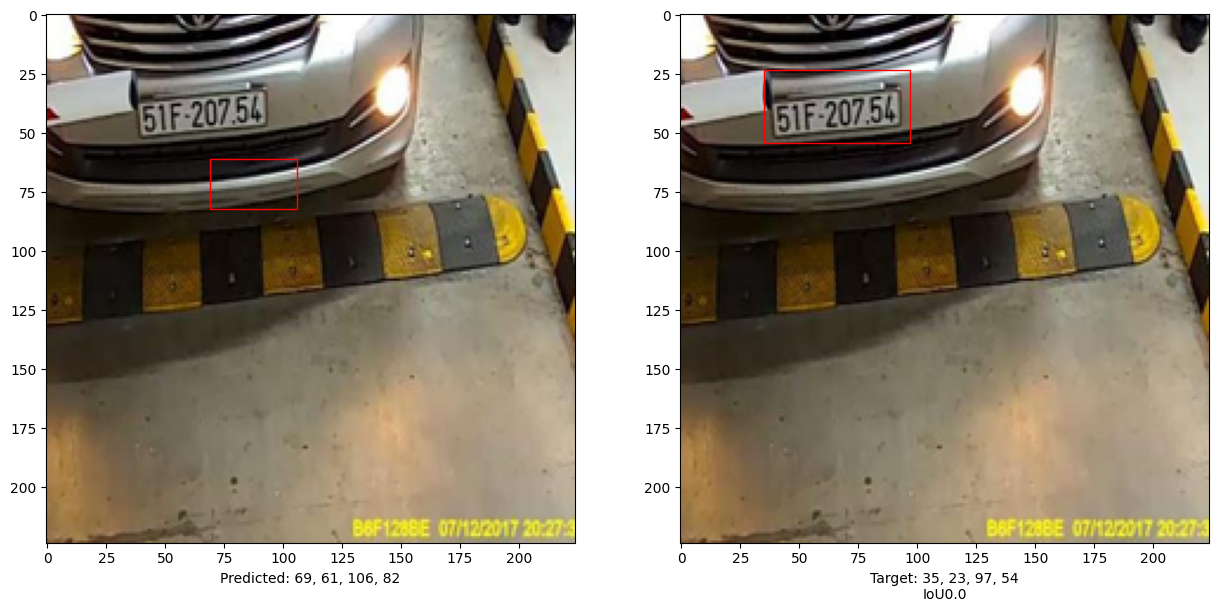

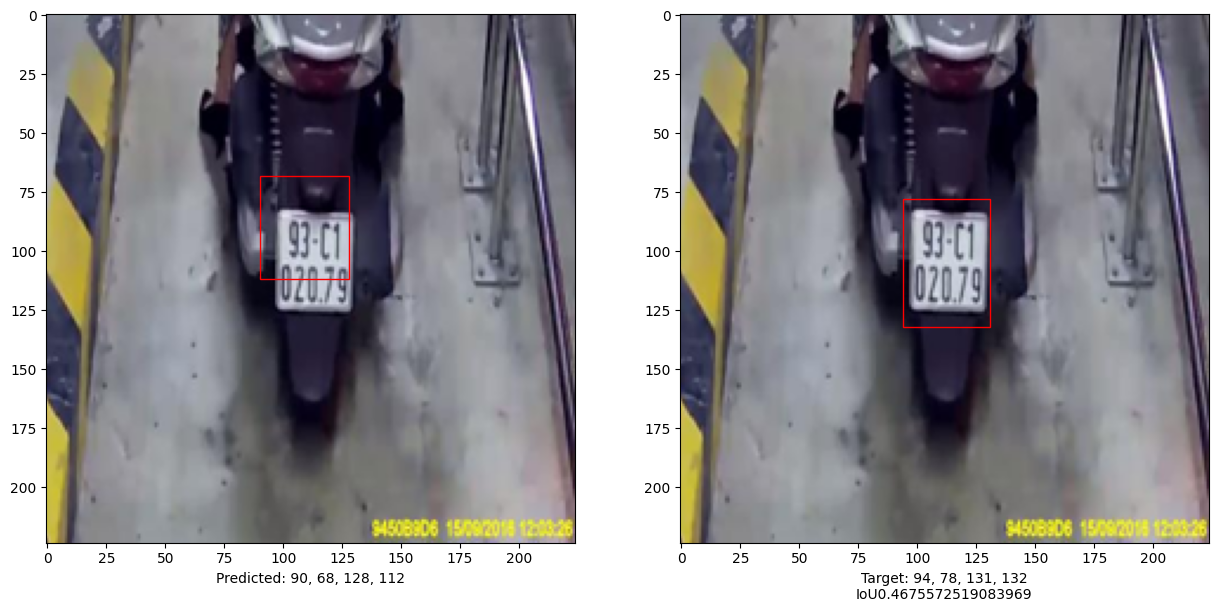

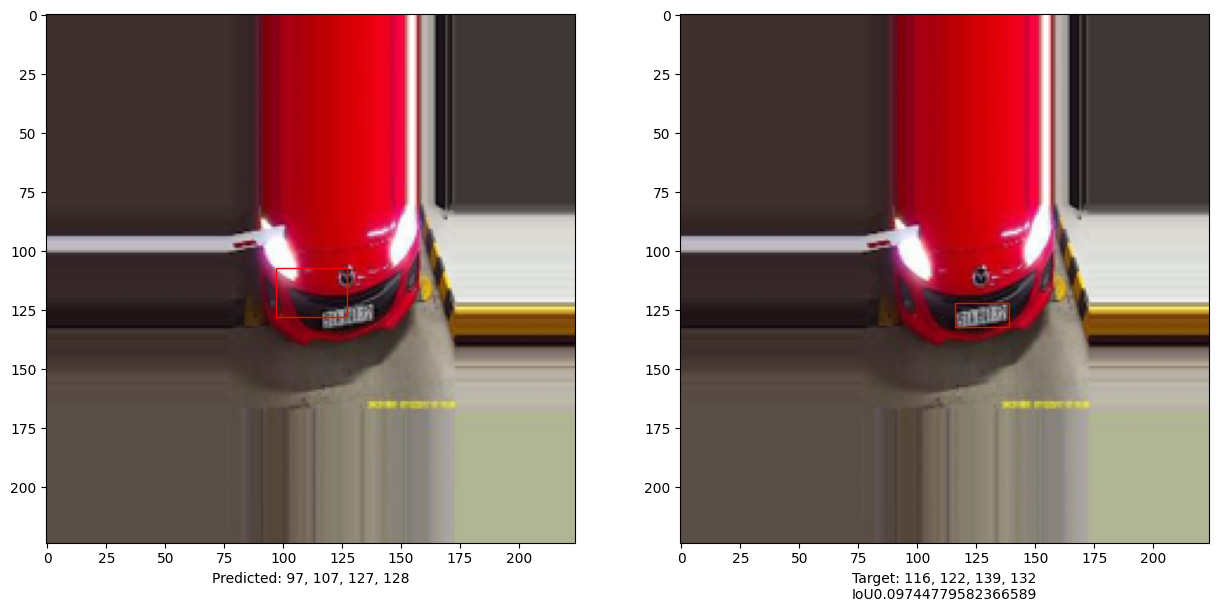

In [13]:
import matplotlib.patches as patches

# To calculate IoU (intersection over union, given two bounding boxes)
def bounding_box_intersection_over_union(box_predicted, box_truth):
    # get (x, y) coordinates of intersection of bounding boxes
    top_x_intersect = max(box_predicted[0], box_truth[0])
    top_y_intersect = max(box_predicted[1], box_truth[1])
    bottom_x_intersect = min(box_predicted[2], box_truth[2])
    bottom_y_intersect = min(box_predicted[3], box_truth[3])

    # calculate area of the intersection bb (bounding box)
    intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(
        0, bottom_y_intersect - top_y_intersect + 1
    )

    # calculate area of the prediction bb and ground-truth bb
    box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (
        box_predicted[3] - box_predicted[1] + 1
    )
    box_truth_area = (box_truth[2] - box_truth[0] + 1) * (
        box_truth[3] - box_truth[1] + 1
    )

    # calculate intersection over union by taking intersection
    # area and dividing it by the sum of predicted bb and ground truth
    # bb areas subtracted by  the interesection area

    # return ioU
    return intersection_area / float(
        box_predicted_area + box_truth_area - intersection_area
    )


i, mean_iou = 0, 0

# Compare results for 10 images in the test set
for input_image in x_test[:10]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    im = input_image

    # Display the image
    ax1.imshow(im.astype("uint8"))
    ax2.imshow(im.astype("uint8"))

    input_image = cv2.resize(
        input_image, (image_size, image_size), interpolation=cv2.INTER_AREA
    )
    input_image = np.expand_dims(input_image, axis=0)
    preds = vit_object_detector.predict(input_image)[0]
    print(preds)
    (h, w) = (im).shape[0:2]

    top_left_x, top_left_y = int(preds[0] * w), int(preds[1] * h)

    bottom_right_x, bottom_right_y = int(preds[2] * w), int(preds[3] * h)

    box_predicted = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax1.add_patch(rect)
    ax1.set_xlabel(
        "Predicted: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
    )

    top_left_x, top_left_y = int(y_test[i][0] * w), int(y_test[i][1] * h)

    bottom_right_x, bottom_right_y = int(y_test[i][2] * w), int(y_test[i][3] * h)

    box_truth = top_left_x, top_left_y, bottom_right_x, bottom_right_y

    mean_iou += bounding_box_intersection_over_union(box_predicted, box_truth)
    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax2.add_patch(rect)
    ax2.set_xlabel(
        "Target: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
        + "\n"
        + "IoU"
        + str(bounding_box_intersection_over_union(box_predicted, box_truth))
    )
    i = i + 1

print("mean_iou: " + str(mean_iou / len(x_test[:10])))
plt.show()

## Compute Mean IoU for Test Images

In [ ]:
i, mean_iou = 0, 0

# Compare results for the test set
for input_image in x_test:
    input_image = cv2.resize(
        input_image, (image_size, image_size), interpolation=cv2.INTER_AREA
    )
    input_image = np.expand_dims(input_image, axis=0)
    preds = vit_object_detector.predict(input_image)[0]
    print(preds)
    (h, w) = (im).shape[0:2]

    # Predictions
    top_left_x, top_left_y = int(preds[0] * w), int(preds[1] * h)

    bottom_right_x, bottom_right_y = int(preds[2] * w), int(preds[3] * h)

    box_predicted = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]

    top_left_x, top_left_y = int(y_test[i][0] * w), int(y_test[i][1] * h)

    bottom_right_x, bottom_right_y = int(y_test[i][2] * w), int(y_test[i][3] * h)

    box_truth = top_left_x, top_left_y, bottom_right_x, bottom_right_y

    mean_iou += bounding_box_intersection_over_union(box_predicted, box_truth)
    
    i = i + 1

print("mean_iou: " + str(mean_iou / len(x_test)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
[0.55129623 0.6706892  0.7245028  0.7842433 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[0.5114874  0.71000516 0.69163024 0.8227128 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[0.51177305 0.53483635 0.6571728  0.63393116]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[0.3859825 0.6017579 0.5618768 0.7420539]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[0.40812212 0.40193582 0.586322   0.53616536]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[0.5745474  0.711391   0.74976337 0.82278097]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[0.46661928 0.48859268 0.5466931  0.53207034]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[0.30938786 0.27652952 0.47733068 0.37033087]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[0.40496242 0.306735   0.5724822  0.5039189 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[0.4340348  0.48008442 0.5683028  0.575714  ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[0.48154885 0.63656974 0.6717073  0.74340117]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[0.3774031  0.34578994 0.53418356 0.44922